In [ ]:
# test the idea of vectorized cross correlation for 
# strided images, rectangular windows and extended search area
# in one function

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.fft import rfft2, irfft2

In [3]:
from openpiv.pyprocess import moving_window_array, \
                            normalize_intensity,\
                            fft_correlate_strided_images, \
                            find_subpixel_peak_position, \
                            get_field_shape, \
                            correlation_to_displacement
from openpiv.tools import imread

In [4]:
frame_a = imread('../test1/exp1_001_a.bmp')
frame_b = imread('../test1/exp1_001_b.bmp')

# frame_a = frame_a[:64,:64]
# frame_b = frame_b[:64,:64]

frame_a = normalize_intensity(frame_a)
frame_b = normalize_intensity(frame_b)

In [5]:
# for debugging purposes 
# frame_a = frame_a[:64,:64]
# frame_b = frame_b[:64,:64]

In [6]:
# parameters for the test
window_size = 32
overlap = 16
search_size = window_size #not extended search for a while

In [7]:
# for the regular square windows case:
aa = moving_window_array(frame_a, window_size, overlap)
bb = moving_window_array(frame_b, window_size, overlap)

In [8]:
c = fft_correlate_strided_images(aa,bb)
n_rows, n_cols = get_field_shape(frame_a.shape, search_size, overlap)
u,v = correlation_to_displacement(c, n_rows,n_cols,search_area_size=window_size)

In [9]:
# let's assume we want the extended search type of PIV analysis
# with search_area_size in image B > window_size in image A
window_size = 16
overlap = 16
search_size = 32  

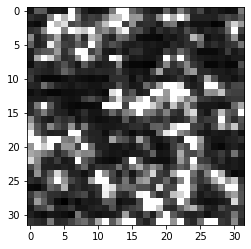

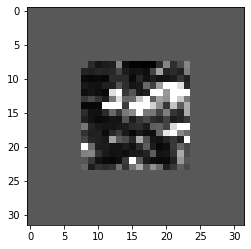

In [10]:
# for the regular square windows case:
aa = moving_window_array(frame_a, search_size, overlap)
bb = moving_window_array(frame_b, search_size, overlap)

aa = normalize_intensity(aa)
bb = normalize_intensity(bb)

# make it use only a small window inside a larger window
plt.figure()
plt.imshow(aa[-1,:,:],cmap=plt.cm.gray)


mask = np.zeros((search_size,search_size))
pad = np.int((search_size - window_size) / 2)

mask[slice(pad,search_size-pad),slice(pad,search_size-pad)] = 1

mask = np.broadcast_to(mask, aa.shape)


aa *= mask


plt.figure()
plt.imshow(aa[-1,:,:],cmap=plt.cm.gray)

In [11]:
c1 = fft_correlate_strided_images(aa,bb)

In [12]:
c.shape, c1.shape

((660, 63, 63), (660, 63, 63))

In [13]:
n_rows, n_cols = get_field_shape(frame_a.shape, search_area_size=search_size, overlap=overlap)

In [14]:
u1,v1 = correlation_to_displacement(c1,n_rows,n_cols,search_area_size=search_size)

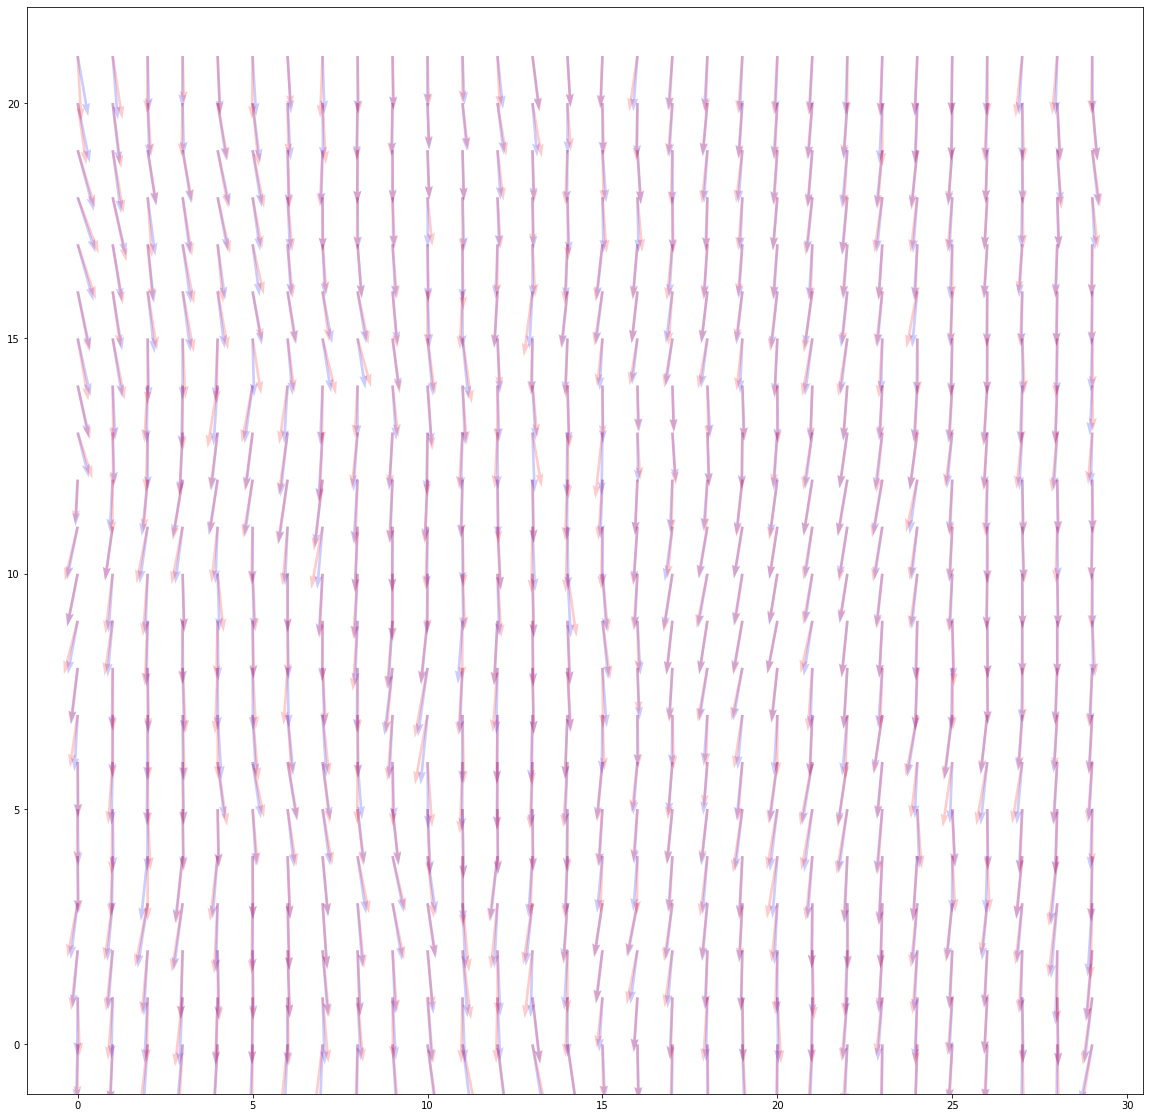

In [15]:
plt.figure(figsize=(20,20))
plt.quiver(u,v,scale=100,color='b',alpha=0.2)
plt.quiver(u1,v1,scale=100,color='r',alpha=0.2)